In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

np.random.seed(123)
tf.random.set_seed(123)

In [5]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from sklearn.metrics import mean_absolute_percentage_error

In [7]:
!gdown --id 1rqK3daDGWczq_BZ1fKD4Nh7ZIRpgIadP

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1rqK3daDGWczq_BZ1fKD4Nh7ZIRpgIadP
To: /content/ML Airline No differncing.xlsx
100% 12.4k/12.4k [00:00<00:00, 16.4MB/s]


In [8]:
df = pd.read_excel('https://drive.google.com/uc?id=1rqK3daDGWczq_BZ1fKD4Nh7ZIRpgIadP', index_col='Month', parse_dates=True)

In [9]:
df['LogPassengers'] = np.log(df['Passengers'])

In [10]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [11]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [12]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [13]:
# Make supervised dataset
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10) Y.shape (133,)


In [14]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [15]:
# Basic ANN
i = Input(shape=(T,))
x = Dense(32, activation='relu')(i)
x = Dense(1)(x)
model = Model(i, x)

In [16]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [17]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=150,
  validation_data=(Xtest, Ytest)
)

Epoch 1/150
4/4 [==============================] - 1s 63ms/step - loss: 0.0143 - val_loss: 0.0113
Epoch 2/150
4/4 [==============================] - 0s 9ms/step - loss: 0.0118 - val_loss: 0.0098
Epoch 3/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0102 - val_loss: 0.0089
Epoch 4/150
4/4 [==============================] - 0s 12ms/step - loss: 0.0093 - val_loss: 0.0085
Epoch 5/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0088 - val_loss: 0.0082
Epoch 6/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0083 - val_loss: 0.0078
Epoch 7/150
4/4 [==============================] - 0s 9ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 8/150
4/4 [==============================] - 0s 12ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 9/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 10/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 11/150
4/4 [===

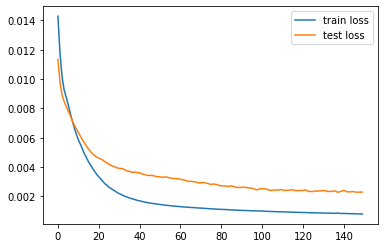

In [18]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [19]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [20]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

1/1 [==============================] - 0s 57ms/step


In [21]:
# Store diff predictions
df.loc[train_idx, 'Diff ANN Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff ANN Test Prediction'] = Ptest

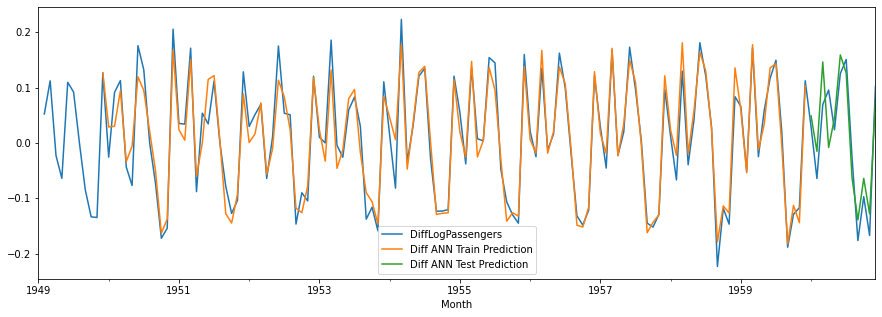

In [22]:
cols = ['DiffLogPassengers',
        'Diff ANN Train Prediction',
        'Diff ANN Test Prediction']
df[cols].plot(figsize=(15, 5));

In [23]:
# Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [24]:
# Last-known train value
last_train = train.iloc[-1]['LogPassengers']

In [25]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

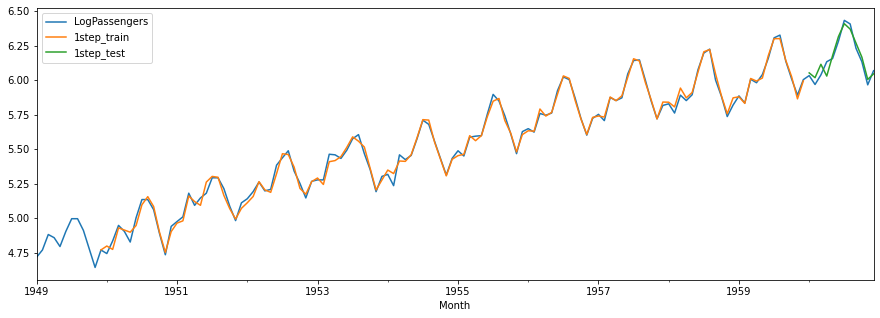

In [26]:
# plot 1-step forecast
df[['LogPassengers', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [27]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1))[0]
  
  # update the predictions list
  multistep_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 [==============================] - 0s 52ms/step


In [28]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

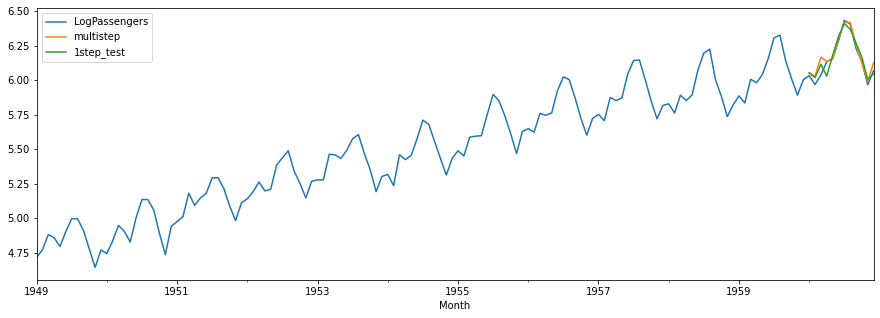

In [29]:
# plot 1-step and multi-step forecast
df[['LogPassengers', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [30]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10) Y.shape (122, 12)


In [31]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [32]:
# Basic ANN
i = Input(shape=(Tx,))
x = Dense(32, activation='relu')(i)
x = Dense(Ty)(x)
model = Model(i, x)

In [33]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [34]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=150,
  validation_data=(Xtest_m, Ytest_m)
)

Epoch 1/150
4/4 [==============================] - 1s 71ms/step - loss: 0.0144 - val_loss: 0.0104
Epoch 2/150
4/4 [==============================] - 0s 23ms/step - loss: 0.0135 - val_loss: 0.0103
Epoch 3/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0127 - val_loss: 0.0103
Epoch 4/150
4/4 [==============================] - 0s 14ms/step - loss: 0.0120 - val_loss: 0.0102
Epoch 5/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0115 - val_loss: 0.0101
Epoch 6/150
4/4 [==============================] - 0s 32ms/step - loss: 0.0110 - val_loss: 0.0099
Epoch 7/150
4/4 [==============================] - 0s 23ms/step - loss: 0.0106 - val_loss: 0.0098
Epoch 8/150
4/4 [==============================] - 0s 17ms/step - loss: 0.0103 - val_loss: 0.0096
Epoch 9/150
4/4 [==============================] - 0s 25ms/step - loss: 0.0099 - val_loss: 0.0094
Epoch 10/150
4/4 [==============================] - 0s 42ms/step - loss: 0.0096 - val_loss: 0.0092
Epoch 11/150
4/4 [=

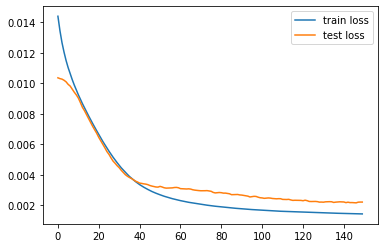

In [35]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [36]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

1/1 [==============================] - 0s 22ms/step


In [37]:
Ptrain.shape, Ptest.shape

((121, 12), (1, 12))

In [38]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

In [39]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + \
  np.cumsum(Ptest)

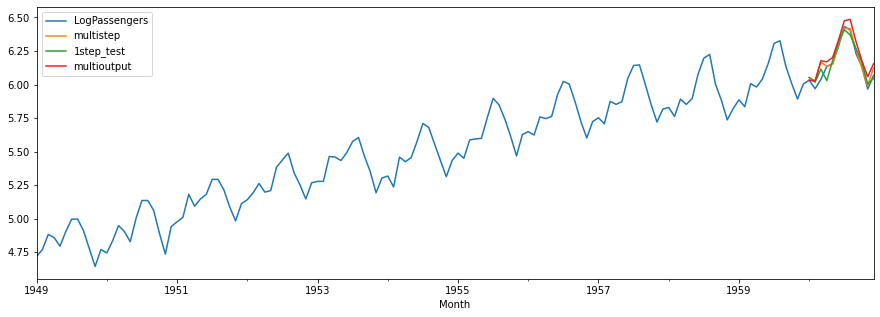

In [40]:
# plot all forecasts
cols = ['LogPassengers', 'multistep', '1step_test', 'multioutput']
df[cols].plot(figsize=(15, 5));

In [41]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.005068560705661482
multi-output MAPE: 0.010290142759699443
